# Machine Learning Algorithm Comparison

This example illustrates fitting and comparing several Machine Learning algorithms for classifying the binary target in the         
HMEQ data set.  
                                                                       
The data set used for this pipeline is from a financial services company that offers a home equity line of credit. 
The company has extended several thousand lines of credit in the past, and many of these accepted 
applicants have defaulted on their loans. Using demographic and financial variables, the company wants to build a model to classify whether an applicant will default.                                       
                                                                          
The target variable "BAD" indicates whether an applicant defaulted on the home equity line of credit.

The steps include:                              
                                                                      
1. PREPARE AND EXPLORE  
  a) Check data is loaded into CAS                               
<br>                                                                      
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model using a Random Forest  
  b) Fit a model using Gradient Boosting  
  c) Fit a model using a Neural Network  
  d) Fit a model using a Support Vector Machine                       
<br>                                                                      
3. EVALUATE AND IMPLEMENT  
  a) Score the data  
  b) Assess model performance  
  c) Generate ROC and Lift charts                                  

### Import packages

In [1]:
import pandas as pd
import swat
from matplotlib import pyplot as plt
from swat.render import render_html

%matplotlib inline

### CAS Server connection details

In [2]:
indata = "hmeq"
indata_ext = ".sas7bdat"

### Start CAS session

In [3]:
sess = swat.CAS("cas01", 19640)

### Import action sets

In [4]:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000214s, mem: 0.048mb

### Load data into CAS if needed

In [5]:
if not sess.table.tableExists(table=indata).exists:
    tbl = sess.upload_file(indata + indata_ext, casout={"name": indata})

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(kesmit).
NOTE: The table HMEQ has been created in caslib CASUSER(kesmit) from binary data uploaded to Cloud Analytic Services.


In [6]:
sess.tableinfo()

,Name,Rows,Columns,Encoding,CreateTimeFormatted,ModTimeFormatted,JavaCharSet,CreateTime,ModTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,HMEQ,5960,13,utf-8,21Sep2016:15:46:51,21Sep2016:15:46:51,UTF8,1.790092e+09,1.790092e+09,0,0,0,,,0,kesmit,


### Explore and Impute missing values

#### View first 5 observations from the data set

In [7]:
tbl.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


#### View table column information

In [8]:
tbl.columninfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,BAD,1,double,8,12,0,0
1,LOAN,2,double,8,12,0,0
2,MORTDUE,3,double,8,12,0,0
3,VALUE,4,double,8,12,0,0
4,REASON,5,char,7,7,0,0
5,JOB,6,char,7,7,0,0
6,YOJ,7,double,8,12,0,0
7,DEROG,8,double,8,12,0,0
8,DELINQ,9,double,8,12,0,0
9,CLAGE,10,double,8,12,0,0


In [9]:
tbl.shape

(5960, 13)

In [10]:
tbl.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66069.000000,3.000000,0.000000,0.000000,115.103197,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119831.500000,13.000000,0.000000,0.000000,231.574834,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


#### Explore data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.000713732 seconds.
----------------------------------Data Summary----------------------------------


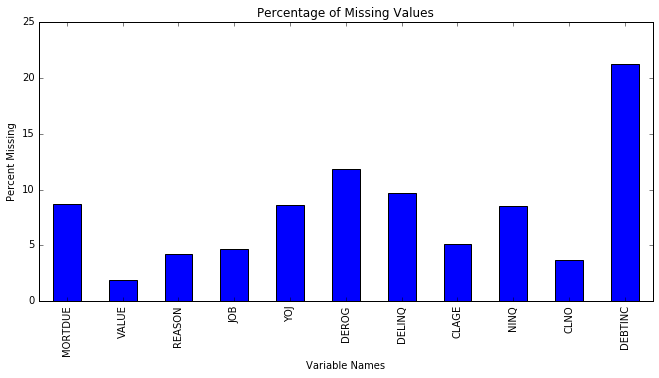

In [11]:
sess.cardinality.summarize(
  table={"name":indata}, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card = sess.CASTable('data_card').query('_NMISS_ > 0')

print("Data Summary".center(80, '-')) # print title

df_data_card = tbl_data_card.to_frame(fetchvars=['_VARNAME_', '_NMISS_', '_NOBS_'])
df_data_card['PERCENT_MISSING'] = (df_data_card['_NMISS_'] / df_data_card['_NOBS_']) * 100

tbl_forplot = pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax = tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values',
  figsize=(11,5)
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

#### Impute missing values

In [12]:
sess.dataPreprocess.transform(
  table={"name":indata},
  casOut={"name":"hmeq_prepped_pr", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq", "debtinc", "yoj", "ninq"}},
    {"impute":{"method":"MODE"}, "inputs":{"job", "reason"}}
  ]
)

[TransInfo]

 Transformation Requests for HMEQ
 
   ActualName  NTransVars ImputeMethod
 0       _TR1           1         Mean
 1       _TR2           4       Median
 2       _TR3           2         Mode

[VarTransInfo]

 Variable Transformation Information for HMEQ
 
   Variable Transformation   ResultVar     N  NMiss  ImputedValueContinuous  \
 0    CLAGE             IM    IM_CLAGE  5652    308              179.766275   
 1  DEBTINC             IM  IM_DEBTINC  4693   1267               34.818262   
 2   DELINQ             IM   IM_DELINQ  5380    580                0.000000   
 3     NINQ             IM     IM_NINQ  5450    510                1.000000   
 4      YOJ             IM      IM_YOJ  5445    515                7.000000   
 5      JOB             IM      IM_JOB  5681    279                     NaN   
 6   REASON             IM   IM_REASON  5708    252                     NaN   
 
   ImputedValueNominal  
 0                      
 1                      
 2                      
 3                      
 4                      
 5               Other  
 6             DebtCon  

[NomVarInfo]

 Nominal Variable Information for HMEQ
 
   Variable       N  NMiss  NLevels
 0      JOB  5681.0  279.0      6.0
 1   REASON  5708.0  252.0      2.0

[OutputCasTables]

             casLib             Name  Rows  Columns  \
 0  CASUSER(kesmit)  hmeq_prepped_pr  5960       20   
 
                                             casTable  
 0  CASTable('hmeq_prepped_pr', caslib='CASUSER(ke...  

+ Elapsed: 0.0882s, user: 0.067s, sys: 0.031s, mem: 34.9mb

#### Create new indicator variable for missing DEBTINC values

In [13]:
sess.dataStep.runcode(code = """
                 data hmeq_prepped;
                     set hmeq_prepped_pr;
                     if missing(DEBTINC) then DEBTINC_IND = 1;
                     else DEBTINC_IND = 0;
                run;    
                 """)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),hmeq_prepped_pr,5960,20,"CASTable('hmeq_prepped_pr', caslib='CASUSER(ke..."
,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),hmeq_prepped,5960,21,"CASTable('hmeq_prepped', caslib='CASUSER(kesmi..."


In [14]:
tbl_tmp = sess.CASTable("hmeq_prepped")
tbl_tmp.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,CLNO,DEBTINC,IM_CLAGE,IM_DEBTINC,IM_DELINQ,IM_NINQ,IM_YOJ,IM_JOB,IM_REASON,DEBTINC_IND
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,9.0,NaN,94.366667,34.818262,0.0,1.0,10.5,Other,HomeImp,1.0
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,14.0,NaN,121.833333,34.818262,2.0,0.0,7.0,Other,HomeImp,1.0
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,10.0,NaN,149.466667,34.818262,0.0,1.0,4.0,Other,HomeImp,1.0
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,NaN,NaN,179.766275,34.818262,0.0,1.0,7.0,Other,DebtCon,1.0
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,14.0,NaN,93.333333,34.818262,0.0,0.0,3.0,Office,HomeImp,1.0


### Set variables for input data

In [15]:
target          = "bad"
class_inputs    = ["im_reason", "im_job", "debtinc_ind"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

### Partition data into Training and Validation

In [16]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":"bad"}, 
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Using SEED=456623202 for sampling.


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 22}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

             casLib       Name Label  Rows  Columns  \
 0  CASUSER(kesmit)  hmeq_part        5960       22   
 
                                           casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(kesmit)')  

+ Elapsed: 0.0854s, user: 0.074s, sys: 0.029s, mem: 36.9mb

### Random Forest

In [17]:
sess.help(actionset="decisionTree");

NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Train a decision tree
NOTE:       dtreeScore - Score a table using a decision tree model
NOTE:       dtreeSplit - Split decision tree nodes
NOTE:       dtreePrune - Prune a decision tree
NOTE:       dtreeMerge - Merge decision tree nodes
NOTE:       dtreeCode - Generate DATA step scoring code from a decision tree model
NOTE:       forestTrain - Train a forest
NOTE:       forestScore - Score a table using a forest model
NOTE:       forestCode - Generate DATA step scoring code from a forest model
NOTE:       gbtreeTrain - Train a gradient boosting tree
NOTE:       gbtreeScore - Score a table using a gradient boosting tree model
NOTE:       gbtreecode - Generate DATA step scoring code from a gradient boosting tree model


In [18]:
rf = sess.decisionTree.forestTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=20,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  seed=100,
  OOB=True,
  vote="PROB",
  casOut={"name":"forest_model", "replace":True}
)

# Output model statistics
render_html(rf)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"bad", "_partind_"},
  vote="PROB"
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="""data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_bad1=_rf_predp_; 
    p_bad0=1-p_bad1; end; if _rf_predname_=0 then do; p_bad0=_rf_predp_; p_bad1=1-p_bad0; end; run;"""
)

Forest for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Trees 20 
 Number of Selected Variables (M) 4 
 Random Number Seed 100 
 Bootstrap Percentage (%) 63.212055882 
 Number of Bins 20 
 Number of Variables 13 
 Confidence Level for Pruning 0.25 
 Max Number of Tree Nodes 291 
 Min Number of Tree Nodes 191 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 21 
 Min Number of Levels 21 
 Max Number of Leaves 146 
 Min Number of Leaves 96 
 Maximum Size of Leaves 1137 
 Minimum Size of Leaves 5 
 Out-of-Bag MCR (%) 10.498561841 
 
 
 
 
 OOB Error With Forest Analytics for HMEQ_PART 
 TreeID 
 Trees 
 NLeaves 
 MCR 
 LogLoss 
 ASE 
 RASE 
 MAXAE 
 
 
 0 1 120 0.1370106762 1.1036530842 0.1039476015 0.3224090592 1 
 1 2 243 0.1317711503 1.2020064975 0.1796934604 0.4239026544 1 
 2 3 358 0.1250665247 1.0648005624 0.2165170993 0.4653139793 1 
 3 4 470 0.1202515723 0.9960894197 0.2422090818 0.4921474188 1 
 4 5 614 0.1172295644 0.996200428 0.263578947 0.513399403 1 
 5 6 747 0.1160822249 0.9720501536 0.2734196302 0.5228954295 1 
 6 7 878 0.110709988 0.9587931765 0.2817242559 0.5307770303 1 
 7 8 1005 0.1099903939 0.9484385127 0.286969798 0.5356956207 1 
 8 9 1143 0.1089512839 0.9302111644 0.2901133379 0.538621702 1 
 9 10 1239 0.1095923261 0.9096048541 0.2923998802 0.5407401226 1 
 10 11 1367 0.1086330935 0.9046312834 0.2947209344 0.542882063 1 
 11 12 1497 0.1045312875 0.8949852046 0.2973966767 0.5453408812 1 
 12 13 1643 0.1038120355 0.8862804305 0.2990208019 0.5468279454 1 
 13 14 1779 0.1047710381 0.8908671365 0.3013909477 0.5489908449 1 
 14 15 1899 0.104506232 0.8847120504 0.3028501936 0.5503182658 1 
 15 16 2036 0.1042665388 0.884545379 0.3041146343 0.5514658959 1 
 16 17 2164 0.1047459252 0.8842220138 0.3046925035 0.5519895864 1 
 17 18 2286 0.1059443912 0.8851196913 0.3050670292 0.5523287329 1 
 18 19 2414 0.1042665388 0.8843760018 0.3051261311 0.5523822328 1 
 19 20 2546 0.1049856184 0.8867663662 0.3063140669 0.5534564725 1 
 
 
 
 
 Forest for HMEQ_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 DEBTINC_IND 243.91395118 112.02126828 
 IM_DELINQ 52.362927937 7.7363978972 
 IM_DEBTINC 45.837814362 10.117386013 
 DEROG 32.63791989 6.5329884971 
 IM_CLAGE 25.643408703 2.7750146773 
 IM_JOB 24.528307679 2.2762677724 
 IM_NINQ 23.423821178 2.4255115085 
 IM_YOJ 22.758647168 1.6983972402 
 CLNO 22.263719283 2.0284651304 
 MORTDUE 21.241169221 1.7538408033 
 LOAN 20.651855779 3.6265888785 
 VALUE 18.345612356 2.1351707007 
 IM_REASON 5.9778081547 1.5981960912 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(kesmit) forest_model 5072 39 CASTable('forest_model', caslib='CASUSER(kesmit)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:109
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 32 times)
      0:35    0:109  (occurred 32 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_rf,5960,7,"CASTable('_scored_rf', caslib='CASUSER(kesmit)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_rf,5960,9,"CASTable('_scored_rf', caslib='CASUSER(kesmit)')"


In [19]:
list(rf.keys())

['ModelInfo', 'ErrorMetricInfo', 'DTreeVarImpInfo', 'OutputCasTables']

In [20]:
rf['DTreeVarImpInfo']

,Variable,Importance,Std
0,DEBTINC_IND,243.913951,112.021268
1,IM_DELINQ,52.362928,7.736398
2,IM_DEBTINC,45.837814,10.117386
3,DEROG,32.637920,6.532988
4,IM_CLAGE,25.643409,2.775015
5,IM_JOB,24.528308,2.276268
6,IM_NINQ,23.423821,2.425512
7,IM_YOJ,22.758647,1.698397
8,CLNO,22.263719,2.028465
9,MORTDUE,21.241169,1.753841


### Gradient Boosting

In [21]:
gb = sess.decisionTree.gbtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  casOut={"name":"gb_model", "replace":True}
)

# Output model statistics
render_html(gb)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="""data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_bad1=_gbt_predp_; 
    p_bad0=1-p_bad1; end; if _gbt_predname_=0 then do; p_bad0=_gbt_predp_; p_bad1=1-p_bad0; end; run;"""
)

Gradient Boosting Tree for HMEQ_PART 
 Descr 
 Value 
 
 
 Number of Trees 10 
 Distribution 2 
 Learning Rate 0.1 
 Subsampling Rate 0.5 
 Number of Selected Variables (M) 13 
 Number of Bins 20 
 Number of Variables 13 
 Max Number of Tree Nodes 57 
 Min Number of Tree Nodes 47 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 29 
 Min Number of Leaves 24 
 Maximum Size of Leaves 1440 
 Minimum Size of Leaves 5 
 Random Number Seed 0 
 
 
 
 
 Decision Tree for HMEQ_PART 
 Analysis Variable 
 Importance 
 Std 
 
 
 DEBTINC_IND 130.84701934 96.207964657 
 IM_DEBTINC 29.877528719 19.711368144 
 IM_DELINQ 20.360116 5.3338895179 
 IM_CLAGE 10.35666295 3.9136317203 
 DEROG 8.1858447535 5.5348823741 
 CLNO 7.326855523 2.0332162503 
 VALUE 6.7161612317 2.2283466493 
 IM_JOB 6.5987607753 2.104645775 
 IM_YOJ 6.0000529727 2.1595597084 
 MORTDUE 4.6142162762 2.1234128609 
 IM_NINQ 4.6108044089 2.5487098494 
 LOAN 2.792862403 1.3021276913 
 IM_REASON 1.1489827491 1.9710703771 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(kesmit) gb_model 508 29 CASTable('gb_model', caslib='CASUSER(kesmit)')

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:111
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 32 times)
      0:35    0:111  (occurred 32 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_gb,5960,6,"CASTable('_scored_gb', caslib='CASUSER(kesmit)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_gb,5960,8,"CASTable('_scored_gb', caslib='CASUSER(kesmit)')"


### Neural Network

In [22]:
nn = sess.neuralNet.annTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  hiddens={2},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Output model statistics
render_html(nn)

# Score 
sess.neuralNet.annScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="""data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_bad1=_nn_predp_; 
    p_bad0=1-p_bad1; end; if _nn_predname_=0 then do; p_bad0=_nn_predp_; p_bad1=1-p_bad0; end; run;"""
)

Iteration History 
 Progress 
 Objective 
 Loss 
 Validation Error 
 Step Size 
 L1 Norm 
 L2 Norm 
 MAX Norm 
 Gradient Norm 
 
 
 1 2.8306792905 2.8306792905 0.7938931298 0 1.8945426895 0.593863531 0.435857066 2.3599954451 
 2 1.9855090469 1.9855090469 0.1956974323 0.4237296314 4.81914394 0.9372832072 0.3995647423 0.2715344786 
 3 1.964956083 1.964956083 0.1956974323 1 5.0189726194 1.0039500905 0.4680380251 0.1117931128 
 4 1.4289805935 1.4289805935 0.1630811936 22.475649215 7.866201558 2.244622073 1.1995924532 0.1325133816 
 5 1.4236150719 1.4236150719 0.1637751561 0.0140042309 8.2330811906 2.3239257901 1.2417150432 0.1212720735 
 6 1.4082048974 1.4082048974 0.1637751561 1 9.1853339719 2.4318110629 1.3045608402 0.1534639835 
 7 1.3614988519 1.3614988519 0.1540596808 1.7687144481 11.709245792 2.6007407095 1.3701673691 0.2518555739 
 8 1.3422252195 1.3422252195 0.1547536433 0.3852329147 14.151679241 2.9190905519 1.4633826639 0.2020863318 
 9 1.338933129 1.338933129 0.1568355309 1 16.876371973 3.3678306638 1.6278910698 0.4367216567 
 10 1.3196831551 1.3196831551 0.1526717557 1 16.28703778 3.2693179717 1.5919738686 0.1150605532 
 11 1.3145533144 1.3145533144 0.1540596808 1 16.859225234 3.3555700281 1.6115572643 0.1116593891 
 12 1.3056134424 1.3056134424 0.1540596808 1 17.765572703 3.5032287279 1.6450282641 0.188426248 
 13 1.2874340819 1.2874340819 0.146426093 1 19.362164467 3.7954430706 1.6933416517 0.2972490646 
 14 1.2686733813 1.2686733813 0.1408743928 1 19.87589412 3.9361047008 1.6739456604 0.2479141365 
 15 1.2681241422 1.2681241422 0.1318528799 1 23.005617948 4.5750768436 1.793036929 0.2272274263 
 16 1.2325913493 1.2325913493 0.1353226926 1 21.389098792 4.3327444036 1.701388698 0.1200595911 
 17 1.2117916501 1.2117916501 0.1353226926 1 20.298750698 4.2223501442 1.6395472797 0.1198924277 
 18 1.2031494667 1.2031494667 0.1304649549 1 20.137962563 4.3645261571 1.6235454543 0.224537897 
 19 1.1926340113 1.1926340113 0.1339347675 1 21.161495282 4.6296336658 1.6774288885 0.0822750185 
 20 1.1875569892 1.1875569892 0.1353226926 1 21.908167524 4.8077964542 1.7399918481 0.0797552915 
 21 1.1795641571 1.1795641571 0.1304649549 1 24.093036714 5.3733232379 1.8617682124 0.2350467786 
 22 1.1713208231 1.1713208231 0.1339347675 1 24.344774598 5.4143892235 1.9007143996 0.0624618759 
 23 1.1675532825 1.1675532825 0.1304649549 1 24.54998528 5.4450039492 1.9164209692 0.0771357954 
 24 1.1644831825 1.1644831825 0.1290770298 1 24.410137431 5.4083815526 1.9081244973 0.0827288638 
 25 1.159650354 1.159650354 0.1290770298 1 25.16037135 5.608642548 1.9199707461 0.1855494188 
 26 1.1570921054 1.1570921054 0.1311589174 0.3873181439 25.314123665 5.6291970094 1.9394118596 0.0633974226 
 27 1.1560002532 1.1560002532 0.1297709924 1 25.817330577 5.749390046 1.9696200923 0.0586019494 
 28 1.1524382256 1.1524382256 0.1269951423 1 26.094883816 5.8183212782 1.9881506963 0.0388051379 
 29 1.1506925445 1.1506925445 0.1269951423 0.433720371 25.972289937 5.774732763 1.9933131065 0.0627875149 
 30 1.149187731 1.149187731 0.1276891048 1 26.472685706 5.9093047982 2.0197919109 0.0384474037 
 31 1.1483291516 1.1483291516 0.1283830673 1 26.740319854 5.9749213684 2.0328815248 0.0411788925 
 32 1.1455321368 1.1455321368 0.1283830673 1 27.768573691 6.2162880755 2.0803813908 0.041177449 
 33 1.1451905593 1.1451905593 0.1290770298 0.0307638608 27.775810207 6.207665268 2.0807839817 0.0864014464 
 34 1.1428949972 1.1428949972 0.1276891048 1 28.778163533 6.4405398841 2.2351326467 0.0623418842 
 35 1.1392449477 1.1392449477 0.1256072172 1 29.42745155 6.5774470582 2.3945833938 0.0533933355 
 36 1.1334274348 1.1334274348 0.1235253296 1 30.701478382 6.8440689746 2.8259242821 0.0820912466 
 37 1.1315632535 1.1315632535 0.1221374046 1 31.70924028 7.1135464106 3.0586207847 0.0615613106 
 38 1.1286073933 1.1286073933 0.1249132547 1 31.483172899 7.053140143 3.0401919893 0.030212554 
 39 1.1268603606 1.1268603606 0.1242192922 1 31.904719013 7.1509825286 3.1766819817 0.0201048545 
 

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:109
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 32 times)
      0:35    0:109  (occurred 32 times)


,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_nn,5960,4,"CASTable('_scored_nn', caslib='CASUSER(kesmit)')"
,casLib,Name,Rows,Columns,casTable
0,CASUSER(kesmit),_scored_nn,5960,6,"CASTable('_scored_nn', caslib='CASUSER(kesmit)')"


### Support Vector Machine

In [23]:
sv = sess.svm.svmTrain(
  table={
    "name":"hmeq_part", 
    "where":"_partind_=1"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  kernel="POLYNOMIAL",
  degree=2,
  id={"bad", "_partind_"},
  savestate={"name":"svm_astore_model", "replace":True}
)

# Output model statistics
render_html(sv)

# Score using ASTORE
render_html(sess.astore.score(
  table={"name":"hmeq_part"},
  rstore={"name":"svm_astore_model"},
  out={"name":"_scored_svm", "replace":True}
))

NOTE: SVM training is activated.
NOTE: Wrote 10929 bytes to the savestate file svm_astore_model.


Model Information 
 Descr 
 Value 
 
 
 Task Type C_CLAS 
 Optimization Technique Interior Point 
 Scale YES 
 Kernel Function Polynomial 
 Kernel Degree 2 
 Penalty Method C 
 Penalty Parameter 1 
 Maximum Iterations 25 
 Tolerance 1e-06 
 
 
 
 
 Observations 
 Descr 
 N 
 
 
 Number of Observations Read 4172 
 Number of Observations Used 3381 
 
 
 
 
 Training Results 
 Descr 
 Value 
 
 
 Inner Product of Weights 61.485621478 
 Bias -0.030902475 
 Total Slack (Constraint Violations) 803.54947822 
 Norm of Longest Vector 6.6144307957 
 Number of Support Vectors 915 
 Number of Support Vectors on Margin 820 
 Maximum F 9.2242861052 
 Minimum F -3.384251501 
 Number of Effects 13 
 Columns in Data Matrix 20 
 Columns in Kernel Matrix 231 
 
 
 
 
 Iteration History 
 Iteration 
 Complementarity 
 Feasibility 
 
 
 1 1002173.5349 3141665.2931 
 2 1146.1794706 2029.634243 
 3 206.45156575 220.05770528 
 4 27.327522504 2.2005772E-6 
 5 7.4107217975 5.1757674E-7 
 6 4.3921099214 2.304127E-7 
 7 1.9781933884 8.3948865E-8 
 8 1.4370881171 4.7023301E-8 
 9 0.5208088253 1.0371652E-8 
 10 0.2003918815 1.9398065E-9 
 11 0.1173152113 8.713565E-10 
 12 0.0666236246 3.892865E-10 
 13 0.0425686627 1.864289E-10 
 14 0.0351930774 1.20305E-10 
 15 0.0229514463 6.909817E-11 
 16 0.0154325983 3.273337E-11 
 17 0.0099116656 1.692008E-11 
 18 0.0059553316 7.606138E-12 
 19 0.0035718034 3.314515E-12 
 20 0.0018483936 8.169576E-13 
 21 0.0008064443 2.411936E-13 
 22 0.0003175807 2.561203E-13 
 23 0.0000745325 1.394449E-13 
 24 6.4221743E-6 8.326673E-14 
 25 1.6987549E-7 8.384457E-13 
 
 
 
 
 Misclassification Matrix 
 Observed 
 0 
 1 
 Total 
 
 
 0 2589 123 2712 
 1 238 431 669 
 Total 2827 554 3381 
 
 
 
 
 Fit Statistics 
 Statistic 
 Training 
 
 
 Accuracy 0.893226856 
 Error 0.106773144 
 Sensitivity 0.9546460177 
 Specificity 0.644245142

Task Timing 
 Task 
 Seconds 
 Percent 
 
 
 Loading the Store 0.0000190735 0.0000763847 
 Creating the State 0.0201158524 0.0805591361 
 Scoring 0.2295641899 0.9193492023 
 Total 0.2497029305 1

### Assess Models

In [24]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_bad1"}],      
      response="bad",
      event="1",
      pVar={"p_bad0"},
      pEvent={"0"}      
    )

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

svmAssess=assess_model(prefix="svm")    
svm_fitstat =svmAssess.FitStat
svm_rocinfo =svmAssess.ROCInfo
svm_liftinfo=svmAssess.LIFTInfo

### Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [25]:
# Add new variable to indicate type of model
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"
svm_liftinfo["model"]="SVM"
svm_rocinfo["model"]="SVM"

# Append data
all_liftinfo = rf_liftinfo.append(gb_liftinfo, ignore_index=True) \
    .append(nn_liftinfo, ignore_index=True) \
    .append(svm_liftinfo, ignore_index=True)  
all_rocinfo = rf_rocinfo.append(gb_rocinfo, ignore_index=True) \
    .append(nn_rocinfo, ignore_index=True) \
    .append(svm_rocinfo, ignore_index=True) 

#### Print AUC (Area Under the ROC Curve)

In [26]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.909909
100,GradientBoosting,0.878100
200,NeuralNetwork,0.875123
300,SVM,0.872880


#### Draw ROC and Lift plots

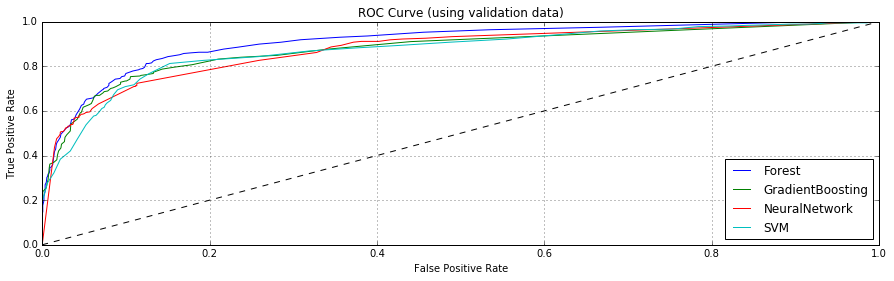

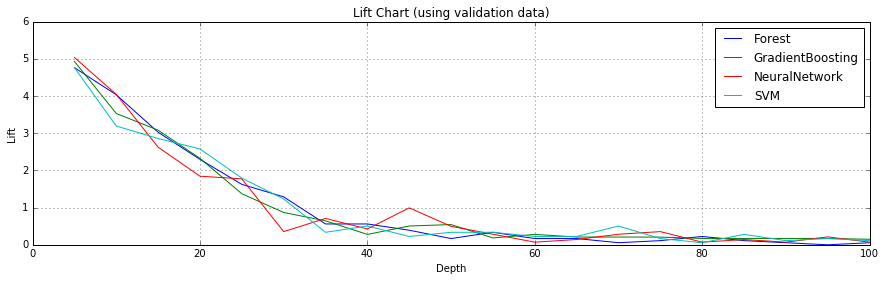

In [27]:
# Draw ROC charts 
plt.figure(figsize=(15,4))
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

# Draw lift charts
plt.figure(figsize=(15,4))
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show()

### End CAS session

In [28]:
sess.close()